In [2]:
!pip install pmdarima

In [2]:
import os
import sys
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import pmdarima as pm
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy import array
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.api import tsa
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_predict
%matplotlib inline
from dateutil.parser import parse 

In [4]:
#Reading the dataset using pandas dataframe
SalesData=pd.read_excel("D:\MSC COMPUTER SCIENCE\Final Dissertation\PROJECT DATASET\Sales_Data 1.xlsx")
#saving the xlsx file to csv file
SalesData.to_csv(r'D:\MSC COMPUTER SCIENCE\Final Dissertation\PROJECT DATASET\SalesData.csv', index = None, header=True)
#checking for null values in rows and columns and displaying
print(SalesData.isnull().all())

InvoiceDate        False
InvoiceNumber      False
DistributorCode    False
Distributor        False
SalesRep           False
CustomerCode       False
Customer           False
CustomerGroup      False
DirectSale         False
LineType           False
ProductCode        False
Product            False
ProductCategory    False
Agency             False
Conv               False
UnitQty            False
BulkQty            False
FreeQty            False
FreeBulkQty        False
UnitPrice          False
GrossValue         False
LineDiscount       False
DocDiscPart        False
NetAmount          False
CustomerTown       False
DistributorArea    False
District           False
dtype: bool


In [5]:
#dropping attributes that are not releavant
SalesData=SalesData.drop(columns=["InvoiceNumber", "SalesRep", "CustomerCode", "DistributorCode"])
#grouping columns
SalesData.groupby(['Agency', 'Product', 'Customer','Distributor'])
#saving it to csv file with new name
SalesData.to_csv("D:\MSC COMPUTER SCIENCE\Final Dissertation\PROJECT DATASET\SalesData.xlsx")
#displaying first 20 rows
SalesData.head(5)

,InvoiceDate,Distributor,Customer,CustomerGroup,DirectSale,LineType,ProductCode,Product,ProductCategory,Agency,...,FreeQty,FreeBulkQty,UnitPrice,GrossValue,LineDiscount,DocDiscPart,NetAmount,CustomerTown,DistributorArea,District
0,1/1/2022 9:40:07 AM,Peumi Pharmaceuticals,Premier Pharmacy,Pharmacies,No,Order,606365,"Diabetasol Sweetener, sachets 50s",Pharmaceuticals,Kalbe Nutritionals,...,0,0,285.22,570.44,0.0,0,570.44,Moratuwa,Colombo - A,Colombo - A
1,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Order,600720,"Dometic 10Mg Tabs , 5 X 10'S",Pharmaceuticals,Kalbe Pharma,...,0,0,306.96,3069.60,0.0,0,3069.60,Matara,Matara,Matara
2,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Free,600720,"Dometic 10Mg Tabs , 5 X 10'S",Pharmaceuticals,Kalbe Pharma,...,0,1,306.96,0.00,0.0,0,0.00,Matara,Matara,Matara
3,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Order,600706,Clavamox 500 Tabs 625Mg 3 X 10'S,Pharmaceuticals,Kalbe Pharma,...,0,0,2049.13,2049.13,0.0,0,2049.13,Matara,Matara,Matara
4,1/1/2022 10:44:06 AM,Sri Lanka Pharmacy,D.D.R.Pharmacy,Pharmacies,No,Order,600726,Xon Ce Tabs 500Mg 50X2'S,OTC,Kalbe Pharma,...,0,0,1304.50,3913.50,0.0,0,3913.50,Kandy,Kandy,Kandy


In [6]:
len(SalesData)

134068

In [7]:
#Converting String to DateTime by separating year, month, day and time
SalesData['Year']=pd.DatetimeIndex(SalesData['InvoiceDate']).year
SalesData['Month']=pd.DatetimeIndex(SalesData['InvoiceDate']).month
SalesData['Day']=pd.DatetimeIndex(SalesData['InvoiceDate']).day
SalesData['Time']=pd.DatetimeIndex(SalesData['InvoiceDate']).time
#Setting InvoiceDate column as index
SalesData.set_index(pd.to_datetime(SalesData['InvoiceDate']), inplace=True)
#Display
SalesData.head()

,InvoiceDate,Distributor,Customer,CustomerGroup,DirectSale,LineType,ProductCode,Product,ProductCategory,Agency,...,LineDiscount,DocDiscPart,NetAmount,CustomerTown,DistributorArea,District,Year,Month,Day,Time
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2022-01-01 09:40:07,1/1/2022 9:40:07 AM,Peumi Pharmaceuticals,Premier Pharmacy,Pharmacies,No,Order,606365,"Diabetasol Sweetener, sachets 50s",Pharmaceuticals,Kalbe Nutritionals,...,0.0,0,570.44,Moratuwa,Colombo - A,Colombo - A,2022,1,1,09:40:07
2022-01-01 10:10:10,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Order,600720,"Dometic 10Mg Tabs , 5 X 10'S",Pharmaceuticals,Kalbe Pharma,...,0.0,0,3069.60,Matara,Matara,Matara,2022,1,1,10:10:10
2022-01-01 10:10:10,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Free,600720,"Dometic 10Mg Tabs , 5 X 10'S",Pharmaceuticals,Kalbe Pharma,...,0.0,0,0.00,Matara,Matara,Matara,2022,1,1,10:10:10
2022-01-01 10:10:10,1/1/2022 10:10:10 AM,Binelco Marketing(Pvt)Ltd,Channel 25,Pharmacies,No,Order,600706,Clavamox 500 Tabs 625Mg 3 X 10'S,Pharmaceuticals,Kalbe Pharma,...,0.0,0,2049.13,Matara,Matara,Matara,2022,1,1,10:10:10
2022-01-01 10:44:06,1/1/2022 10:44:06 AM,Sri Lanka Pharmacy,D.D.R.Pharmacy,Pharmacies,No,Order,600726,Xon Ce Tabs 500Mg 50X2'S,OTC,Kalbe Pharma,...,0.0,0,3913.50,Kandy,Kandy,Kandy,2022,1,1,10:44:06


In [8]:
#All the unique products sold
ProductSold=SalesData["Product"].unique()
#Display
print(ProductSold)

['Diabetasol Sweetener, sachets 50s' "Dometic 10Mg Tabs  , 5 X 10'S"
 "Clavamox 500 Tabs 625Mg 3 X 10'S" "Xon Ce Tabs 500Mg 50X2'S"
 'Astifen 1mg/5ml Syrup 60ml' 'Dometic Syrup 5mg/5ml, 60 ml   Bottle'
 "Zegavit Tabs , 10 X 5'S" 'Diabetasol Vanila 360gm Tin'
 "Zeos Tablets 10Mg ,5 X 10'S" "Nevox XR ,500mg Tabs,3x10's"
 "ASTIFEN 1MG TABS 10'SX 6" "Diaflam Tabs 50Mg 5 X10'S"
 "Hexilon 4mg Tabs, 5x10's" 'Zeos oral sol 5mg/5ml 60ml'
 'Nocid Tabs 10x10s' 'Mycoral cream 2% 15GM' 'Mycoral cream 2% 5GM'
 'Trifix 100mg/5ml Pow-OralSusp 30ml' 'Diabetasol Vanila 180g'
 "Unitrac 100Mg Caps 3 X 10'S" "Divoltar Tabs 50Mg , 5 X 10'S"
 'Metrix 2mg Tabs 2x15s' 'Car-Q 100 Tabs 30s'
 "Clavamox 250 Tabs 375MG  3x10's" "Citaz 100mg Tabs , 5x10's"
 'Clavamox Inj 1.2gm 1s' 'Trifix 200mg Tabs 3x10s' 'Citicol 500mg 30s'
 "Hexilon 16mg Tabs, 3x10's" 'Rillus Tabs 5x6s' 'Gersia Tabs 5mg 30s'
 'Nutrican  243gm - 3 x81gm sachets' 'KALTROFEN GEL 2.5%,30G'
 'Nephrisol\xa0183gm - 3 x 61gm sachets' 'Entrasol 400gm Tin'

In [9]:
#Products sold based on Net Amount
ProductSoldNet=SalesData[["Product","NetAmount"]].groupby("NetAmount")
#Display
ProductSoldNet.head(25)

,Product,NetAmount
InvoiceDate,,
2022-01-01 09:40:07,"Diabetasol Sweetener, sachets 50s",570.44
2022-01-01 10:10:10,"Dometic 10Mg Tabs , 5 X 10'S",3069.60
2022-01-01 10:10:10,"Dometic 10Mg Tabs , 5 X 10'S",0.00
2022-01-01 10:10:10,Clavamox 500 Tabs 625Mg 3 X 10'S,2049.13
2022-01-01 10:44:06,Xon Ce Tabs 500Mg 50X2'S,3913.50
...,...,...
2022-03-31 13:27:39,"Zeos Tablets 10Mg ,5 X 10'S",48220.00
2022-03-31 13:27:39,"Dometic Syrup 5mg/5ml, 60 ml Bottle",17760.80
2022-03-31 13:37:35,Unitrac 100Mg Caps 3 X 10'S,51150.00


In [10]:
#Most products sold based on Net Amount
ProductSoldMostinNet=SalesData[["Product","NetAmount"]].sort_values(by='NetAmount', ascending=False)
#Display
ProductSoldMostinNet.head()

,Product,NetAmount
InvoiceDate,,
2022-03-07,Xon Ce Tabs 500Mg 50X2'S,3828103.6
2022-02-09,Xon Ce Tabs 500Mg 50X2'S,2607700.0
2022-02-25,Merofen 1gm IV Vial 1's,2318375.0
2022-03-29,Diabetasol Vanila 360gm Tin,2106168.0
2022-02-16,Xon Ce Tabs 500Mg 50X2'S,1955775.0


In [13]:
#Districts in which the products are sold
ProductSoldinDistrict=SalesData["District"].unique()
#Display
print(ProductSoldinDistrict)

['Colombo - A' 'Matara' 'Kandy' 'Badulla' 'Ampara' 'Puttalam'
 'Colombo - B' 'Batticaloa' 'Kurunegala' 'Colombo - C' 'Colombo - D'
 'Ratnapura' 'Colombo 1-15' 'Anuradhapura' 'Galle' 'Jaffna'
 'Tissamaharama']


In [14]:
#Most Products sold in each District based on Net Amount
ProductSoldPerDistrict = {
    District:SalesData[SalesData["District"] == District][["Product", "NetAmount"]].groupby("Product").sum().sort_values(by='NetAmount', ascending=False) for District in ProductSoldinDistrict
}
#Displaying most prducts sold in each District based on Net Amount
for District, Product in ProductSoldPerDistrict.items():
    print(District)
    print(Product.head(), end="\n\n")

Colombo - A
                               NetAmount
Product                                 
Nevox XR ,500mg Tabs,3x10's  11457782.89
Xon Ce Tabs 500Mg 50X2'S     10140529.90
Zeos Tablets 10Mg ,5 X 10'S   4652022.55
Diabetasol Vanila 360gm Tin   3259706.96
Nocid Tabs 10x10s             2470940.97

Matara
                                   NetAmount
Product                                     
Nevox XR ,500mg Tabs,3x10's       9905790.48
Xon Ce Tabs 500Mg 50X2'S          4607141.40
Zeos Tablets 10Mg ,5 X 10'S       2594012.95
Diabetasol Vanila 360gm Tin       1693909.73
Clavamox 500 Tabs 625Mg 3 X 10'S  1272236.69

Kandy
                                    NetAmount
Product                                      
Nevox XR ,500mg Tabs,3x10's       12197020.51
Xon Ce Tabs 500Mg 50X2'S           7546606.10
Diabetasol Vanila 360gm Tin        4288705.12
Citicol 500mg 30s                  3812464.58
Clavamox 500 Tabs 625Mg 3 X 10'S   3491275.60

Badulla
                              NetAmount


In [18]:
#Products sold in Customer Town
ProductSoldinCustomerTown=SalesData["CustomerTown"].unique()
#Display
print(ProductSoldinCustomerTown)

['Moratuwa' 'Matara' 'Kandy' 'Gampola' 'Bandarawela' 'Dehiwala'
 'Piliyandala' 'Boralesgamuwa' 'Soysapura' 'Ampara' 'Mahawewa' 'Hingurana'
 'Horana' 'Malabe' 'Athurugiriya' 'Eravur' 'Ibbagamuwa' 'Gokarella'
 'Hiripitiya' 'Rajagiriya' 'Wattegama' 'Akkaraipattu' 'Gelioya'
 'Peradeniya' 'Nawalapitiya' 'Kegalle' 'Matale' 'Kurunegala' 'Wariyapola'
 'Melsiripura' 'Nikadalupota' 'Kiribathgoda' 'Raddolugama' 'Seeduwa'
 'Negombo' 'Ja-Ela' 'Batticaloa' 'Arayampathy' 'Kathankudi' 'Katugastota'
 'Akurana' 'Kundasale' 'Chilaw' 'Meegoda' 'Eheliyagoda' 'Awissawella'
 'Galagedara' 'Colombo  3' 'Nugegoda' 'Deniyaya' 'Weligama' 'Giriulla'
 'Kelaniya' 'Marawila' 'Nattandiya' 'Dummalasooriya' 'Gampaha' 'Atalugama'
 'Aranayake' 'Hingurakgoda' 'Pannala' 'Kuliyapitiya' 'Narammala' 'Galle'
 'Dodangoda' 'Dharga Town' 'Bibile' 'Divulapitiya' 'Colombo  2'
 'Mahiyanganaya' 'Thalawakelle' 'Colombo  4' 'Colombo  6' 'Colombo 15'
 'Padukka' 'Kolonnawa' 'Pitabaddara' 'Morawake' 'Colombo  5' 'Karapitiya'
 'Karandeniya'

In [19]:
#Products sold in customers Town based on  Net Amount
ProductSoldinCustomerTown=SalesData[["CustomerTown","Product","NetAmount"]].groupby(["CustomerTown","Product"]).sum()
#Display
ProductSoldinCustomerTown.head(20)

NetAmount
CustomerTown   Product                                      
Achchuvely     Xon Ce Tabs 500Mg 50X2'S            101751.00
               Zeos oral sol 5mg/5ml 60ml            6017.00
Addalachchenai ASTIFEN 1MG TABS 10'SX 6              1495.00
               Astifen 1mg/5ml Syrup 60ml            1255.50
               Hexilon 4mg Tabs, 5x10's              2023.05
               KALTROFEN GEL 2.5%,30G                7980.00
               Trifix 100mg/5ml Pow-OralSusp 30ml    4247.90
               Zeos Tablets 10Mg ,5 X 10'S           4673.75
               Zeos oral sol 5mg/5ml 60ml            4512.75
Agalawatta     ASTIFEN 1MG TABS 10'SX 6              3737.50
               Astifen 1mg/5ml Syrup 60ml            9043.50
               Car-Q 100 Tabs 30s                   10269.57
               Citicol 500mg 30s                     2817.40
               Clavamox 250 Tabs 375MG  3x10's      12765.26
               Clavamox 500 Tabs 625Mg 3 X 10'S     40982.60
               Diabetasol Sweetener, sachets 50s     2021.31
               Diabetasol Vanila 180g                2215.66
               Diabetasol Vanila 360gm Tin          14825.05
               Divoltar Tabs 50Mg , 5 X 10'S        17233.91
               Dometic 10Mg Tabs  , 5 X 10'S         1227.84

In [28]:
Distributors=SalesData["Distributor"].unique()
print(Distributors)

['Peumi Pharmaceuticals' 'Binelco Marketing(Pvt)Ltd' 'Sri Lanka Pharmacy'
 'Prabaharan Agencies' 'S & S Distributors' 'ApexMed Pharmaceuticals'
 'Wayamba Distributors' 'G.M.P.Drugs' 'SK Jeelan (Pvt) Ltd'
 'A.L.Distributors,' 'Niro Pharma (Pvt) Ltd.'
 'The West Central Pharma (Pvt) Ltd'
 'Seetha Investments(Pvt)Ltd-Ratnapura' 'Hemas' 'National Pharmaceuticals'
 'Sanro Trading(Pvt)Ltd-CMB C' 'Sarath Pharmaceuticals (Pvt) Ltd'
 'Dimath Pharmaceuticals (Private) Limited' 'F T C Ventures (Pvt) Ltd'
 'LIFECONNECT SOLUTIONS(PVT)LTD-CMB 1-15' 'Ram Medical'
 'Seetha Investments(Pvt)Ltd' 'Omindu Pharmaceuticals(Pvt)Ltd'
 'Lanka Pharmacy - Galle' 'Chandrasiri Distributors (Pvt) Ltd'
 'Perera Pharmacy (PVT) Ltd' 'Lanka Pharmacy - Matara'
 'Perera Pharmacy (Pvt) Ltd - Matara' 'Paranagama Associates(Pvt)Ltd']


In [29]:
Customers=SalesData["Customer"].unique()
print(Customers)

['Premier Pharmacy' 'Channel 25' 'D.D.R.Pharmacy' ...
 'Kasun Bandara Amarakoon Dr.' 'Madola D.T.S.Dr.' 'Bizra Medical']


In [31]:
CustomerGroup=SalesData["CustomerGroup"].unique()
print(CustomerGroup)

['Pharmacies' 'Hospitals - Private' 'Cash Customr-Counter'
 'Doct-(Excluding Vet)' 'Oth Pvt Medical Inst' 'Semi Government Inst'
 'Optical Institutions' 'Super Market' 'Staff' 'Doctor-(Veterinary)'
 'Osu Sala' 'Hospitals - Govt.' 'Farms, Forage Stores' 'SMSRT' 'Other'
 'Small Grocery' 'Whole Sale Shop' 'Other Govt Inst.' 'Armed Forces'
 'SPC / CPU']


In [33]:
#Highest sale month 
BestSales=SalesData.groupby('Month').sum()
#Months range between 1 and 3 based on source data
months=range(1,4)

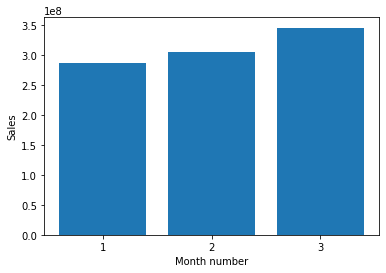

In [34]:
#Visualization
plt.bar(months,BestSales['NetAmount'])
plt.xticks(months)
plt.xlabel("Month number")
plt.ylabel("Sales")
plt.show()

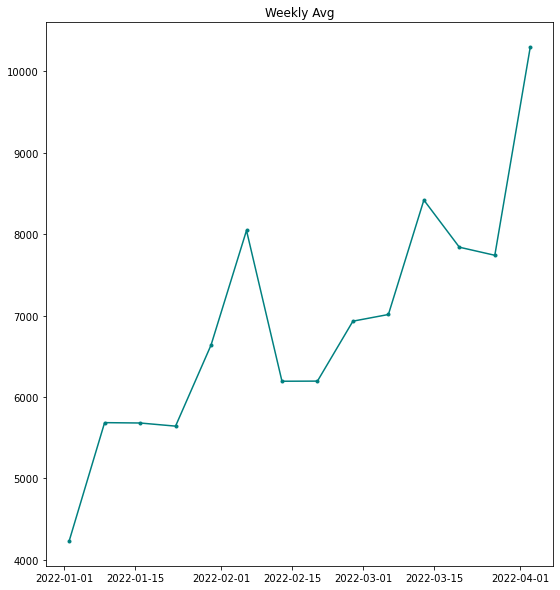

In [35]:
#Weekly Sales Distribution
price_weekly_avg = SalesData.resample('W').apply(np.mean)
#Monthly Sales Distribution
price_monthly_avg = SalesData.resample('M').apply(np.mean)
#Visualization of Weekly Sales Distribution
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.NetAmount, "-o", markersize=3, color='teal')

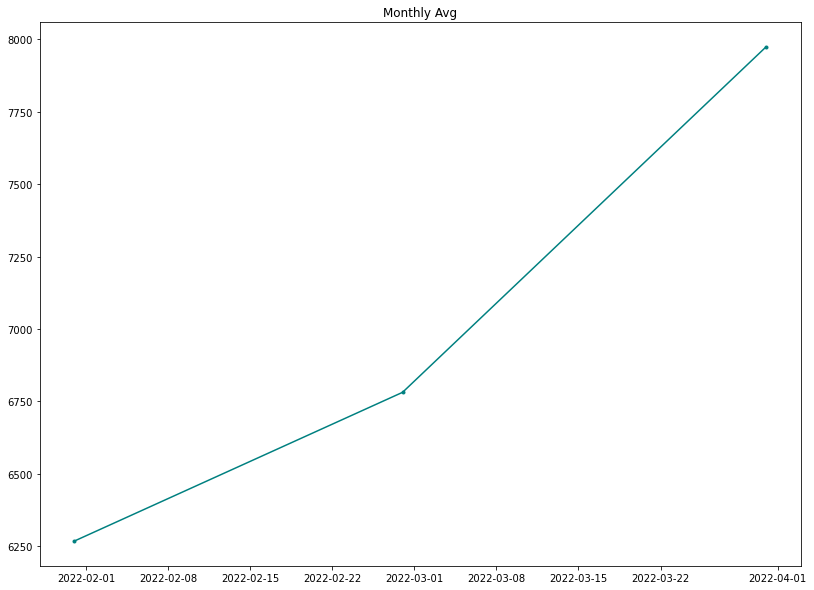

In [36]:
#Visualization of Monthly Sales Distribution
plt.figure(figsize=(30,10))
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.NetAmount, "-o", markersize=3, color='teal')

In [37]:
#Checking whether data is sationary or not
x=SalesData['NetAmount'].values
result=adfuller(x)
print("ADF",result[0])
print("pvalue",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF -53.36445026673498
pvalue 0.0
critical values 3142863.128556435
Data is stationary


In [38]:
SalesData.describe()

,ProductCode,Conv,UnitQty,BulkQty,FreeQty,FreeBulkQty,UnitPrice,GrossValue,LineDiscount,DocDiscPart,NetAmount,Year,Month,Day
count,134068.000000,134068.0,134068.0,134068.000000,134068.0,134068.000000,134068.000000,1.340680e+05,134068.000000,134068.0,1.340680e+05,134068.0,134068.000000,134068.000000
mean,602955.506713,1.0,0.0,11.351426,0.0,0.285072,1016.221134,6.998551e+03,6.143363,0.0,6.992408e+03,2022.0,1.982979,16.932176
std,2600.477242,0.0,0.0,44.144284,0.0,1.780356,1047.030628,3.059508e+04,287.309206,0.0,3.055282e+04,0.0,0.815057,8.481221
min,600694.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000e+00,2022.0,1.000000,1.000000
25%,600706.000000,1.0,0.0,1.000000,0.0,0.000000,313.050000,9.887100e+02,0.000000,0.0,9.887100e+02,2022.0,1.000000,10.000000
50%,602512.000000,1.0,0.0,3.000000,0.0,0.000000,703.050000,2.600000e+03,0.000000,0.0,2.600000e+03,2022.0,2.000000,18.000000
75%,604809.000000,1.0,0.0,10.000000,0.0,0.000000,1304.500000,5.947830e+03,0.000000,0.0,5.947830e+03,2022.0,3.000000,24.000000
max,608924.000000,1.0,0.0,2936.000000,0.0,150.000000,7670.930000,3.828104e+06,35888.460000,0.0,3.828104e+06,2022.0,3.000000,31.000000


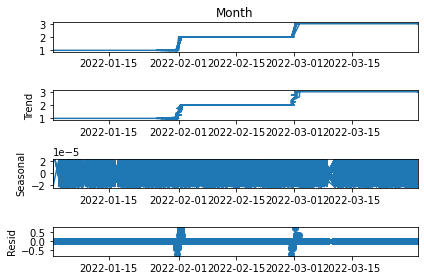

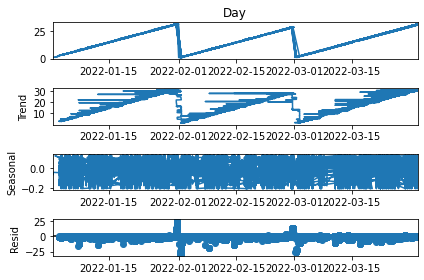

In [39]:
#Seasonal decomposition of data 
temp = SalesData.copy()
temp['Month']=pd.DatetimeIndex(temp.index).month
temp['Day']= pd.DatetimeIndex(temp.index).day
Monthdecomposition = sm.tsa.seasonal_decompose(temp['Month'], model='additive',period=4) 
Daydecomposition = sm.tsa.seasonal_decompose(temp['Day'], model='additive',period=365)
fig = Monthdecomposition.plot()
fig1 = Daydecomposition.plot()

In [40]:
#Spliting data to train and test
traindata=SalesData['NetAmount'][:int(len(SalesData)*0.8)]
testdata=SalesData['NetAmount'][int(len(SalesData)*0.2)]

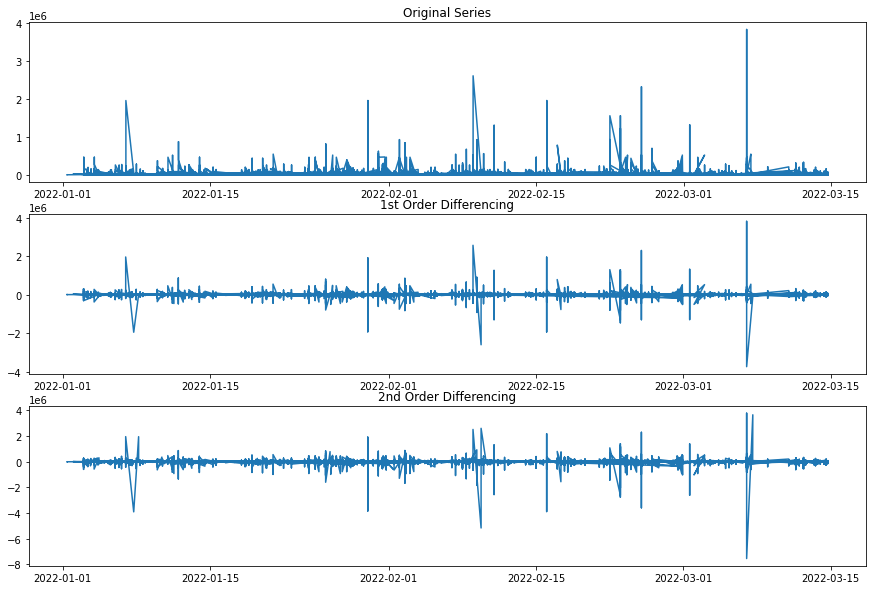

In [41]:
#Comparing the difference
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 10))
ax1.plot(traindata)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(True)
# 1st Differencing
ax2.plot(traindata.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(True)
# 2nd Differencing
ax3.plot(traindata.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(True)
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

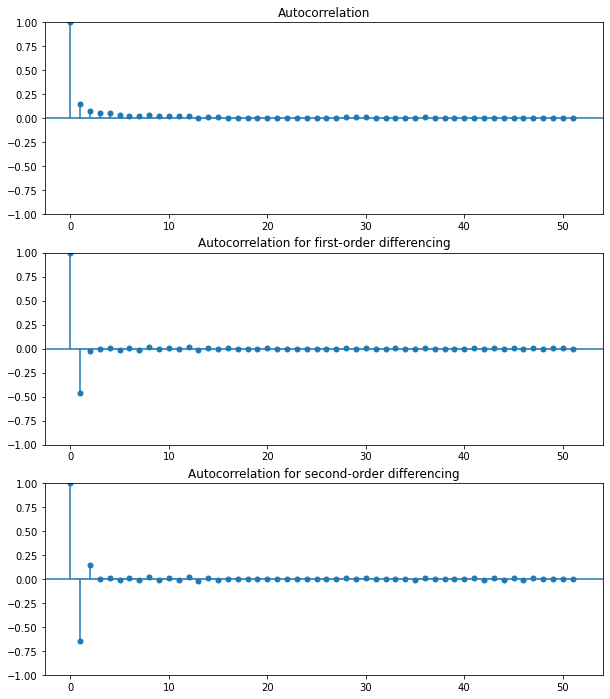

In [42]:
#Autocorrelation
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
autocorr= plot_acf(traindata, ax=ax1)
autocorr2 = plot_acf(traindata.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
autocorr3= plot_acf(traindata.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation for second-order differencing')

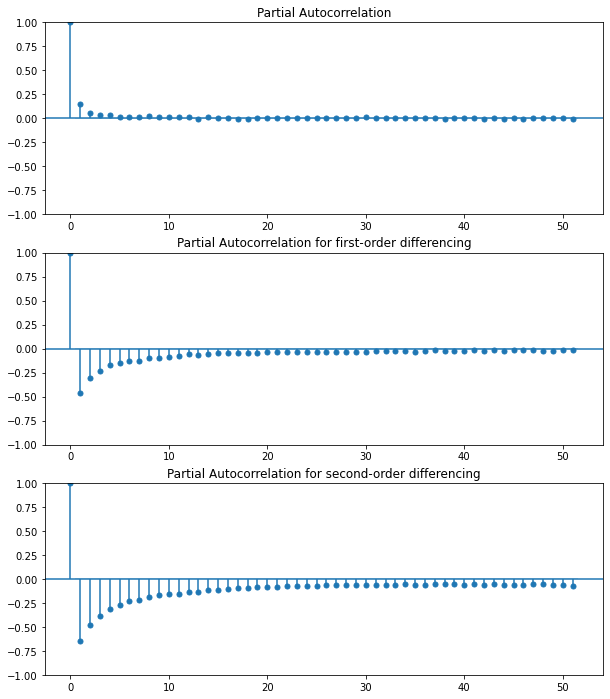

In [43]:
#Partial Autocorrelation
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
parautocorr= plot_pacf(traindata, ax=ax1)
parautocorr2 = plot_pacf(traindata.diff().dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation for first-order differencing')
parautocorr3= plot_pacf(traindata.diff().diff().dropna(), ax=ax3)
ax3.set_title('Partial Autocorrelation for second-order differencing')

In [85]:
#Spliting data to train and test for ARIMA analysis
from statsmodels.tsa.arima.model import ARIMA
Traindata=SalesData['NetAmount'][:int(len(SalesData)*0.8)]
Testdata=SalesData['NetAmount'][:int(len(SalesData)*0.2)]
#Training the model
model = ARIMA(Traindata, order=(1,1,2))
model_fit = model.fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsm

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


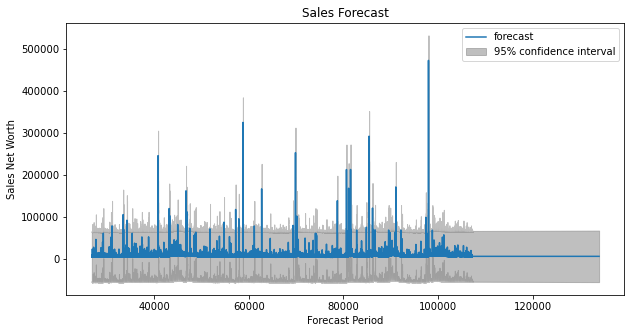

In [86]:
#Visualization
fig,axs = plt.subplots(1, 1, figsize=(10,5))
Results=plot_predict(model_fit, start=len(Testdata), end=(len(SalesData)-1), ax=axs)
plt.title("Sales Forecast")
plt.xlabel("Forecast Period")
plt.ylabel("Sales Net Worth")
plt.show()

In [87]:
#Defining SARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
def optimize_SARIMA(parameters_list, d, D, s, exog): 
    results = []    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(maxiter=5, disp=5)
        except:
            continue        
        aic = model.aic
        results.append([param, aic])   
    sarimaresults = pd.DataFrame(results)
    sarimaresults.columns = ['(p,q)x(P,Q)', 'AIC']
    return sarimaresults

In [88]:
#Running SARIMA model with defined parameters
from itertools import product
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 3
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [89]:
#SARIMA Model Taining
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
sarimaresults= optimize_SARIMA(parameters_list, 1,1,3, SalesData['NetAmount'])

  0%|          | 0/81 [00:00<?, ?it/s]

MemoryError: Unable to allocate 124. MiB for an array with shape (11, 11, 134068) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1004, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions.MemoryError: Unable to allocate 124. MiB for an array with shape (11, 11, 134068) and data type float64


Text(0, 0.5, 'Net Worth of Sales')

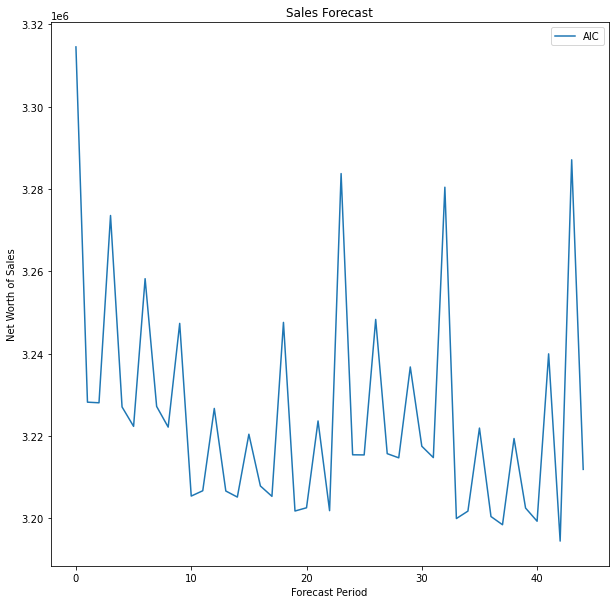

In [92]:
sarimaresults.plot(figsize=(10,10))
plt.title("Sales Forecast")
plt.xlabel("Forecast Period")
plt.ylabel("Net Worth of Sales")

In [93]:
#Train and Test Split for Regresion Model
train = SalesData['NetAmount'][:-int(len(SalesData['NetAmount'])/10)]
test = SalesData['NetAmount'][:-int(len(SalesData['NetAmount'])/10)]
x_train,x_test,y_train,y_test=train_test_split(train,test,test_size=0.2,train_size=0.8,random_state=1)

In [94]:
#Fitting data in the model 
x_train = sm.add_constant(x_train)
model = sm.GLS(y_train, x_train)
result = model.fit()

print(result.summary())

                            GLS Regression Results                            
Dep. Variable:              NetAmount   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.901e+34
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:44:48   Log-Likelihood:             2.1226e+06
No. Observations:               96529   AIC:                        -4.245e+06
Df Residuals:                   96527   BIC:                        -4.245e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.354e-12   2.25e-13     14.902      0.0